In [293]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [294]:
# Getting the data 1
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
dataset_path = '../datasets/'
dataset_file = 'bank+marketing.zip'
dataset_full_path = os.path.join(dataset_path, dataset_file)
response = requests.get(url)
with open(f'{dataset_path}bank+marketing.zip', 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

with zipfile.ZipFile(f'{dataset_path}bank+marketing.zip') as zip_ref:
    zip_ref.extractall(f'{dataset_path}/bank+marketing')

with zipfile.ZipFile(f'{dataset_path}/bank+marketing/bank.zip') as zip_ref:
    zip_ref.extractall(f'{dataset_path}/bank+marketing')

In [295]:
bank = pd.read_csv(f'{dataset_path}/bank+marketing/bank-full.csv', sep=';')

In [296]:
df = bank[
    ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign',
     'pdays', 'previous', 'poutcome', 'y']]

In [297]:
df.loc[:, 'y'] = df['y'].map({'yes': 1, 'no': 0})

In [298]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
df_test, df_train = train_test_split(df, test_size=0.6, random_state=1)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=1)
len(df), len(df_train), len(df_test), len(df_val)

(45211, 27127, 9042, 9042)

In [299]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [300]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [301]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [302]:
# Question 1: ROC AUC feature importance
# ROC AUC could also be used to evaluate feature importance of numerical variables.
# 
# Let's do that
# 
# For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
# Use the training dataset for that
# If your AUC is < 0.5, invert this variable by putting "-" in front
# 
# (e.g. -df_train['engine_hp'])
# 
# AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
# 
# Which numerical variable (among the following 4) has the highest AUC?
# 
# balance
# day
# duration
# previous


In [303]:
def train_logistic_regression(features, df_train, y_train, C=1.0):
    dv = DictVectorizer(sparse=False)
    dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(dict)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [304]:
def predict_logistic_regression(features, df, dv, model):
    dict = df[features].to_dict(orient='records')
    X_val = dv.transform(dict)
    y_pred = model.predict_proba(X_val)[:, 1]
    return y_pred

In [305]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')

In [306]:
all_features = categorical + numerical
all_without_balance = list(filter(lambda x: 'balance' not in x, all_features))
all_without_day = list(filter(lambda x: 'day' not in x, all_features))
all_without_duration = list(filter(lambda x: 'duration' not in x, all_features))
all_without_previous = list(filter(lambda x: 'previous' not in x, all_features))

In [307]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_balance

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.8705406780924718)

In [308]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_day

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.8723618961654769)

In [309]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_duration

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.7268139273176828)

In [310]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_without_previous

dv, model = train_logistic_regression(features, df_train, y_train, C=0.001)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred)

np.float64(0.8704997370045363)

In [311]:
# Question 2: Training the model
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
# 
# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# What's the AUC of this model on the validation dataset? (round to 3 digits)
# 
# 0.69
# 0.79
# 0.89
# 0.99

In [312]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
features = all_features

dv, model = train_logistic_regression(features, df_train, y_train)
y_pred = predict_logistic_regression(features, df_val, dv, model)
roc_auc_score(y_val, y_pred).round(3)

np.float64(0.913)

In [313]:
# Question 3: Precision and Recall
# Now let's compute precision and recall for our model.
# 
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them
# At which threshold precision and recall curves intersect?
# 
# 0.265
# 0.465
# 0.665
# 0.865

In [314]:
accuracy_score(y_val, y_pred >= 0.5)

0.90687900906879

In [315]:
thresholds = np.linspace(0, 1, 100)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.115
0.01 0.226
0.02 0.357
0.03 0.473
0.04 0.570
0.05 0.647
0.06 0.703
0.07 0.743
0.08 0.774
0.09 0.800
0.10 0.818
0.11 0.831
0.12 0.843
0.13 0.853
0.14 0.861
0.15 0.868
0.16 0.874
0.17 0.877
0.18 0.882
0.19 0.884
0.20 0.887
0.21 0.890
0.22 0.893
0.23 0.895
0.24 0.895
0.25 0.897
0.26 0.900
0.27 0.901
0.28 0.902
0.29 0.902
0.30 0.904
0.31 0.905
0.32 0.905
0.33 0.906
0.34 0.906
0.35 0.906
0.36 0.906
0.37 0.906
0.38 0.906
0.39 0.906
0.40 0.906
0.41 0.907
0.42 0.908
0.43 0.907
0.44 0.908
0.45 0.907
0.46 0.907
0.47 0.907
0.48 0.907
0.49 0.907
0.51 0.907
0.52 0.907
0.53 0.906
0.54 0.906
0.55 0.906
0.56 0.905
0.57 0.906
0.58 0.904
0.59 0.904
0.60 0.904
0.61 0.903
0.62 0.903
0.63 0.903
0.64 0.902
0.65 0.902
0.66 0.901
0.67 0.901
0.68 0.900
0.69 0.900
0.70 0.899
0.71 0.899
0.72 0.899
0.73 0.899
0.74 0.898
0.75 0.898
0.76 0.897
0.77 0.897
0.78 0.896
0.79 0.896
0.80 0.895
0.81 0.894
0.82 0.894
0.83 0.894
0.84 0.893
0.85 0.893
0.86 0.892
0.87 0.891
0.88 0.891
0.89 0.891
0.90 0.890
0.91 0.889

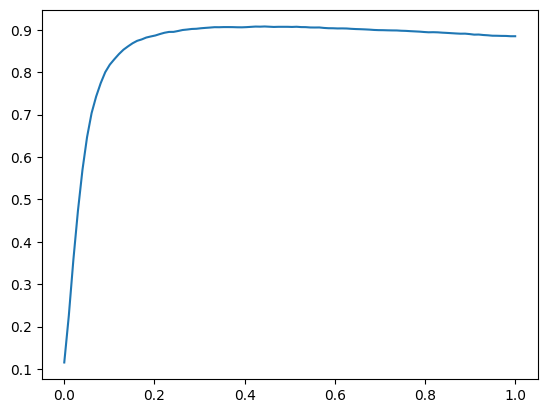

In [316]:
plt.plot(thresholds, scores)

In [317]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [318]:
precision = tp / (tp + fp)
precision

np.float64(0.6695059625212947)

In [319]:
recall = tp / (tp + fn)
recall

np.float64(0.37752161383285304)

In [320]:
tpr = tp / (tp + fn)
tpr

np.float64(0.37752161383285304)

In [321]:
fpr = fp / (fp + tn)
fpr

np.float64(0.024246969128858892)

In [322]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

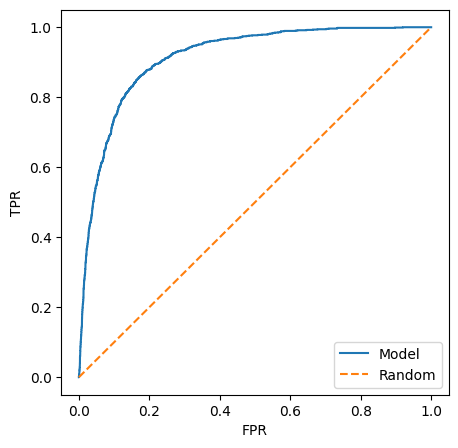

In [323]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()